In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#import warnings, string
import warnings
import string
#warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter

In [3]:
df=pd.read_csv('preprocessed reviews dataset.csv')

In [4]:
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [7]:
df.dropna(inplace=True)

In [8]:
# adding a new column to get length of the review string
df['length'] = df['text_'].apply(len)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40431 non-null  object 
 1   rating    40431 non-null  float64
 2   label     40431 non-null  object 
 3   text_     40431 non-null  object 
 4   length    40431 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [10]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                 
             mean         std   min   25%    50%    75%     max  
label                                                            
CG     173.267722  173.614884  13.0  57.0   99.0  216.0  1300.0  
OR     237.060200  251.930537   8.0  74.0  134.0  295.0  2224.0

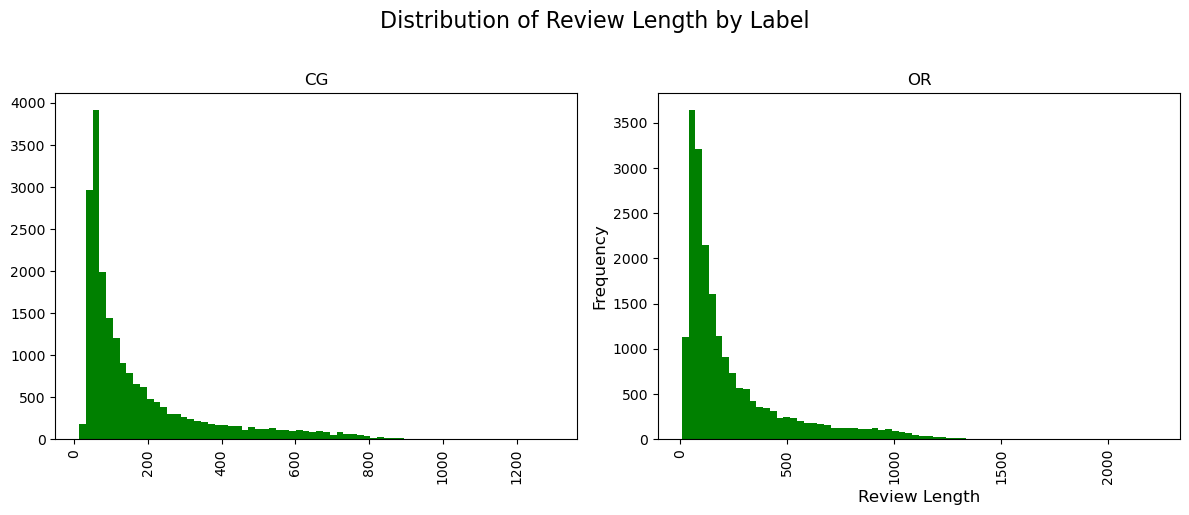

In [11]:
df.hist(column='length',by='label', bins=70,color='green',figsize=(12,5))
plt.suptitle("Distribution of Review Length by Label", y=1.02, fontsize=16)
plt.xlabel("Review Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Correlation analysis between numerical columns (rating and length)
correlation_matrix = df[['rating', 'length']].corr()

# Category-specific analysis: Average review length and proportion of labels by category
category_analysis = df.groupby('category').agg(
    avg_length=('length', 'mean'),
    total_reviews=('label', 'count'),
    genuine_proportion=('label', lambda x: (x == 'CG').mean())  # Assuming 'CG' indicates genuine
).sort_values(by='total_reviews', ascending=False)

# Display the correlation matrix and category-specific summary
correlation_matrix, category_analysis.head()


(          rating    length
 rating  1.000000 -0.074546
 length -0.074546  1.000000,
                     avg_length  total_reviews  genuine_proportion
 category                                                         
 Kindle_Store_5      248.722199           4730                 0.5
 Books_5             253.916705           4370                 0.5
 Pet_Supplies_5      177.941232           4254                 0.5
 Home_and_Kitchen_5  181.374507           4056                 0.5
 Electronics_5       209.278335           3988                 0.5)

In [13]:
# describing the largest review
#df['label']=='OR' filters the DataFrame by the label 'OR'.
#.sort_values(by='length', ascending=False) sorts the data by text length.
#.head() retrieves the top 5 longest texts.
#.iloc[0] gets the first row (longest text).
#.text_ extracts the text_ column (the actual text).

df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

"weak on current scienc after see twice i agr much posit five star review out respect read review i 'll repeat everyth i like present i found goofi over ear hairdo facial hair arrang daniel vitali describ `` wild food expert `` distract ugh ditto david wolf extrem goofi wild hairdo on hand jon gabriel describ `` author weight loss expert `` nice groom good present hi stori person transform fellow pound whew becom jock normal weight inspir christian northrup preserv rank one america 's cutest doctor a realli nice look woman present dr. mercola jason vale kri carr alejandro junger fine it disappoint jami oliv popular uk give babi cow growth fluid pas unscientif popular idea milk none present anyth zilch say work doctor t. colin campbel milk bodi bad it good see present take stand sugar they agr evil sugar refin carbohydr with respect dr. northrup `` it 's fat make fat 's sugar `` statement pas muster commun expert recogn evil sugar not mutual exclu recogn proven danger fat particularli f

In [14]:
df.length.describe()

count    40431.000000
mean       205.164750
std        218.682902
min          8.000000
25%         64.000000
50%        116.000000
75%        253.000000
max       2224.000000
Name: length, dtype: float64

In [15]:
# filtering out important words in the review
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x000001A0C60AD9E0>)

In [17]:
# text is represented as a collection of word counts
# It converts a collection of text documents into a matrix of token counts, where each row represents a document and each column represents a unique word (or token)

In [18]:
# analyzer=text_process= allows to clean and tokenize the text before converting it into a document-term matrix for further analysis or machine learning tasks

In [19]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


KeyboardInterrupt: 

In [ ]:
# bow_transformer then creates a vocabulary dictionary where the keys are the unique words, and the values are their corresponding indices in the feature space.
# bow_transformer.vocabulary is a dictionary that holds the vocabulary that CountVectorizer learned after calling fit().
# Each unique word (token) in the corpus (the text data) is assigned a unique index
#len(bow_transformer.vocabulary_):returns the size of the vocabulary, i.e., the number of unique terms (words) that the vectorizer learned from the text.

In [17]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 34202


In [18]:
# example review
review5= df['text_'][4]
review5

'veri nice set good qualiti we set two month'

In [19]:
bow_msg5 = bow_transformer.transform([review5])
print(bow_msg5)
print(bow_msg5.shape)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (1, 34202)>
  Coords	Values
  (0, 13271)	1
  (0, 19942)	1
  (0, 20751)	1
  (0, 24239)	1
  (0, 26772)	2
  (0, 31267)	1
  (0, 32185)	1
(1, 34202)


In [20]:
# (0, 13271) represents that at index 13271 in the vocabulary build, the word occurs once in the review.

In [21]:
# bow_msg5.shape:The shape of the matrix bow_msg4 is (1, n_features). The 1 represents the single review (since we passed one review to transform()).
# n_features is the number of features in the vocabulary (the total unique words), which is the same as the number of unique words in the vocabulary learned by the CountVectorizer

In [22]:
#  (1, 34202) indicates that the sparse matrix has 1 row (for the single review) and 34,452 columns (representing the total vocabulary size).

In [23]:
# lets see the unique words

In [24]:
print(bow_transformer.get_feature_names_out()[19942])
print(bow_transformer.get_feature_names_out()[26772])

month
set


In [25]:
bow_reviews = bow_transformer.transform(df['text_'])

In [26]:
#shape: This provides insight into the size of your feature matrix. In this case, it's the number of reviews and the number of unique words.
# nnz: tells you about the sparsity of your matrix. A high value of nnz compared to the total size (shape[0] * shape[1]) indicates a relatively dense matrix, while a low value of nnz indicates that the matrix is sparse, meaning that most of the words are not present in most of the reviews.

In [27]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 34202)
Amount of non zero values in the bag of words model: 1012963


In [28]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.07


In [29]:
# t 7% of the matrix is occupied by non-zero elements (or 93% is zeros, making it a sparse matrix)

In [30]:
# transform(bow_reviews) converts the bow_reviews matrix from simple counts to TF-IDF (Term Frequency-Inverse Document Frequency) values.
# TF-IDF scores indicate the importance of a word in a document relative to its occurrence across the entire corpus.
#Higher values mean a word is more unique to a particular document.

tfidf_transformer = TfidfTransformer().fit(bow_reviews)

tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 34202)
No. of Dimensions: 2


In [31]:
tfidf_reviews

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1012963 stored elements and shape (40431, 34202)>

In [32]:
tfidf_transformer

TfidfTransformer()

**creating and training the datasets**

In [33]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

**Decision Tree**

In [39]:
# Optimized Custom Decision Tree ----> this works
from sklearn.base import BaseEstimator, ClassifierMixin
class CustomDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        X = X if not hasattr(X, "toarray") else X.toarray()
        y = np.array(y)
        self.tree = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X, y, depth):
        # Base cases
        if len(set(y)) == 1 or depth == self.max_depth:
            return Counter(y).most_common(1)[0][0]

        # Find best split
        feature, threshold = self._find_best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]

        # Split data
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {"feature": feature, "threshold": threshold, "left": left_tree, "right": right_tree}

    def _find_best_split(self, X, y):
        best_feature, best_threshold, best_gain = None, None, -float("inf")
        n_features = X.shape[1]
    
        for feature_index in range(n_features):
            # Use the dense array directly without .toarray()
            column_data = X[:, feature_index]
            thresholds = np.percentile(column_data, [25, 50, 75])  # Calculate split candidates
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature_index, threshold)
                if gain > best_gain:
                    best_feature, best_threshold, best_gain = feature_index, threshold, gain
    
        return best_feature, best_threshold

    def _information_gain(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        left_y, right_y = y[left_mask], y[right_mask]
        
        left_impurity = self._gini_impurity(left_y)
        right_impurity = self._gini_impurity(right_y)
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        
        return self._gini_impurity(y) - (left_weight * left_impurity + right_weight * right_impurity)

    def _gini_impurity(self, y):
        counts = Counter(y)
        total = len(y)
        return 1 - sum((count / total) ** 2 for count in counts.values())

    def predict(self, X):
        X = X if not hasattr(X, "toarray") else X.toarray()
        return [self._predict_sample(x, self.tree) for x in X]

    def _predict_sample(self, x, tree):
        if isinstance(tree, dict):
            feature_value = x[tree['feature']]
            if feature_value <= tree['threshold']:
                return self._predict_sample(x, tree['left'])
            else:
                return self._predict_sample(x, tree['right'])
        return tree


In [56]:
# Define pipeline
classifier = CustomDecisionTree(max_depth=3)
pipeline = Pipeline([
    ('bow', CountVectorizer(max_features=1000,analyzer=text_process)),  # Bag-of-Words
    ('tfidf', TfidfTransformer()),  # TF-IDF
    ('classifier', classifier)  # Custom decision tree
])

# Fit pipeline
pipeline.fit(review_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001DB8F0309A0>,
                                 max_features=1000)),
                ('tfidf', TfidfTransformer()),
                ('classifier', CustomDecisionTree())])

In [57]:

# predictions
dtree_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,dtree_pred))
print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.54      0.96      0.69      7056
          OR       0.82      0.19      0.31      7095

    accuracy                           0.57     14151
   macro avg       0.68      0.57      0.50     14151
weighted avg       0.68      0.57      0.50     14151

Confusion Matrix: [[6763  293]
 [5751 1344]]
Accuracy Score: 0.5728923750971663
Model Prediction Accuracy: 57.29%


**Random Forest**

In [45]:
# debugging code--------. this works for n-estimator=3
import numpy as np
from collections import Counter
from scipy.sparse import issparse

class CustomRandomForest:
    def __init__(self, n_estimators=10, max_depth=3, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.features_per_tree = []

    def fit(self, X, y):
            if issparse(X):  # Check if sparse
                X = X  # Use sparse matrix directly
            else:
                X = np.array(X)  # Convert to dense if not sparse
            if hasattr(X, 'toarray'):
                X = X.toarray()  # Ensure it's dense if sparse
            X = np.array(X)
            y = np.array(y)
    
            for _ in range(self.n_estimators):
                # Randomly select features
                max_features = self.max_features
                if max_features == 'sqrt':
                    max_features = int(np.sqrt(X.shape[1]))
                elif max_features == 'log2':
                    max_features = int(np.log2(X.shape[1]))
                else:
                    max_features = X.shape[1]
                
                selected_features = np.random.choice(X.shape[1], max_features, replace=False)
                #print(f"Selected features for tree: {selected_features}")  # Debug log
                self.features_per_tree.append(selected_features)
                
                # Train each tree
                tree = CustomDecisionTree(max_depth=self.max_depth)
                tree.fit(X[:, selected_features], y)
                self.trees.append(tree)
    
            return self

    def predict(self, X):
        if hasattr(X, 'toarray'):
            X = X.toarray()  # Ensure it's dense if sparse
        X = np.array(X)
        
        predictions = []
        for tree, features in zip(self.trees, self.features_per_tree):
            print(f"Predicting with features: {features}")  # Debug log
            tree_preds = tree.predict(X[:, features])
            predictions.append(tree_preds)

        predictions = np.array(predictions)
        # Majority voting
        return [Counter(predictions[:, i]).most_common(1)[0][0] for i in range(predictions.shape[1])]

# Text processing pipeline function
def text_process(text):
    text = text.lower()  # Example preprocessing step
    return text.split()  # Tokenization


In [49]:
from sklearn.pipeline import Pipeline
rf_classifier = CustomRandomForest(n_estimators=5, max_depth=3, max_features=10)
pipeline = Pipeline([
    ('bow',CountVectorizer(max_features=5000,analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',rf_classifier)
])

In [50]:
print("Shape of review_train:", review_train.shape)
print("Shape of label_train:", label_train.shape)


Shape of review_train: (26280,)
Shape of label_train: (26280,)


In [51]:
pipeline.fit(review_train,label_train)
random_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,random_pred))
print('Confusion Matrix:',confusion_matrix(label_test,random_pred))
print('Accuracy Score:',accuracy_score(label_test,random_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,random_pred)*100,2)) + '%')

Predicting with features: [2276  645 3639 ... 1661 3613 3146]
Predicting with features: [2917  863 3206 ... 4863 4394 3882]
Predicting with features: [ 959 1784 4629 ... 2335 1133 1397]
Predicting with features: [2288 1972 4794 ... 2458 1532  662]
Predicting with features: [4469 1491 3088 ... 4300  344 2793]
Classification Report:               precision    recall  f1-score   support

          CG       0.78      0.52      0.62      7033
          OR       0.64      0.85      0.73      7118

    accuracy                           0.69     14151
   macro avg       0.71      0.69      0.68     14151
weighted avg       0.71      0.69      0.68     14151

Confusion Matrix: [[3646 3387]
 [1041 6077]]
Accuracy Score: 0.6870892516429934
Model Prediction Accuracy: 68.71%


**Naive Bayes**

In [52]:
from sklearn.utils.sparsefuncs import mean_variance_axis
import numpy as np
from sklearn import datasets
class NaiveBayes:

    def fit(self, X, y): 
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            mean, var = mean_variance_axis(X_c, axis=0)  # Compute mean and variance for sparse data
            self._mean[idx, :] = mean
            self._var[idx, :] = var
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
    
    # Ensure x is dense and 1D
        if hasattr(x, "toarray"):  # Check if x is sparse
            x = x.toarray().flatten()
        else:
            x = np.asarray(x).flatten()  # Ensure x is a 1D numpy array
    
    # Perform element-wise Gaussian PDF computation
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator


        print(f"x shape: {x.shape}, mean shape: {mean.shape}, var shape: {var.shape}")

In [53]:
X= df['text_']
y= df['label']
review_train, review_test, label_train, label_test = train_test_split(X,y,test_size=0.35,random_state=123)

In [56]:
from sklearn.pipeline import Pipeline
classifier = NaiveBayes()
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process,max_features=15000)),
    ('tfidf',TfidfTransformer()),
    ('classifier',NaiveBayes())
])

In [57]:
pipeline.fit(review_train,label_train)
naive_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,naive_pred))
print('Confusion Matrix:',confusion_matrix(label_test,naive_pred))
print('Accuracy Score:',accuracy_score(label_test,naive_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,naive_pred)*100,2)) + '%')

C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_19724\3387760802.py:51: RuntimeWarning: invalid value encountered in divide
  numerator = np.exp(-((x - mean) ** 2) / (2 * var))
C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_19724\3387760802.py:51: RuntimeWarning: divide by zero encountered in divide
  numerator = np.exp(-((x - mean) ** 2) / (2 * var))
C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_19724\3387760802.py:53: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator
C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_19724\3387760802.py:33: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self._pdf(idx, x)))
C:\Users\SAKSHI\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

Classification Report:               precision    recall  f1-score   support

          CG       0.50      1.00      0.67      7056
          OR       0.00      0.00      0.00      7095

    accuracy                           0.50     14151
   macro avg       0.25      0.50      0.33     14151
weighted avg       0.25      0.50      0.33     14151

Confusion Matrix: [[7056    0]
 [7095    0]]
Accuracy Score: 0.49862200551197794
Model Prediction Accuracy: 49.86%


C:\Users\SAKSHI\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAKSHI\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**K-NN**

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 2: Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(review_train)
X_test = vectorizer.transform(review_test)

In [59]:
# optimized code for k-nn
import numpy as np
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import cdist

class OptimizedKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train= None
        

    def fit(self, X, y):
        '''Fit the KNN model on the training data'''
        # Convert the training data to the appropriate format (e.g., array, sparse matrix)
        self.X_train = X.toarray()  # Assuming X is a sparse matrix or DataFrame
        
        # Assign and reset the index of y_train
        self.y_train = y.reset_index(drop=True)
        
        # Any other setup if needed (e.g., distance matrix calculation)
        #print("Training model with data of shape:", self.X_train.shape)

    def _precompute_distances(self, X_test):
        '''Precompute the distance matrix between the test and training data'''
        X_test_dense = X_test.toarray()  # Convert sparse matrix to dense
        return cdist(X_test_dense, self.X_train, metric='euclidean')

    def _get_neighbors(self, distances, k):
        '''Get the indices of the k-nearest neighbors for each test point'''
        try:
            # Get indices of k nearest neighbors
            nearest_neighbors = np.argsort(distances)[:k]
            
            # # Debug: Validate neighbors
            # print(f"Nearest neighbors indices: {nearest_neighbors}")
            # print(f"Valid index range: 0 to {len(self.y_train) - 1}")
            
            # Check for invalid indices
            for idx in nearest_neighbors:
                if idx < 0 or idx >= len(self.y_train):
                    raise ValueError(f"Invalid index {idx} in nearest neighbors.")
    
            return nearest_neighbors
        except Exception as e:
            print(f"Error in _get_neighbors: {e}")
            raise

    def _predict_single(self, test_point_index, distances, k):
        '''Predict the label for a single test point'''
        try:
            nearest_neighbors = self._get_neighbors(distances[test_point_index], k)
            
            # Ensure all indices are valid
            valid_neighbors = [nn for nn in nearest_neighbors if 0 <= nn < len(self.y_train)]
            if not valid_neighbors:
                raise ValueError(f"No valid neighbors found for test point {test_point_index}.")
            
            # Debug: Show valid neighbors and corresponding labels
            #print(f"Valid nearest neighbors for test point {test_point_index}: {valid_neighbors}")
            nearest_labels = [self.y_train.iloc[idx] for idx in valid_neighbors]  # Using .iloc for position-based access
            #print(f"Labels for neighbors: {nearest_labels}")
            
            # Compute the most common label
            return Counter(nearest_labels).most_common(1)[0][0]
        except Exception as e:
            print(f"Error in _predict_single for test point {test_point_index}: {e}")
            raise


    def predict(self, X_test):
        '''Predict the labels for the test data'''
        distances = self._precompute_distances(X_test)
    
        # # Debugging distances
        # print(f"Distance matrix shape: {distances.shape}")
        # print(f"Sample distances for test point 0: {distances[0]}")
    
        try:
            predictions = []
            with ThreadPoolExecutor() as executor:
                predictions = list(executor.map(lambda i: self._predict_single(i, distances, self.k), range(X_test.shape[0])))
    
            return np.array(predictions)
        except Exception as e:
            print(f"Error in predict method: {e}")
            raise

In [68]:
# Create the pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer( stop_words='english',max_features=12000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', OptimizedKNN(k=3))  # Use custom KNN classifier
])

In [69]:
# Fit and transform the training data
X_train = vectorizer.fit_transform(review_train)
X_test = vectorizer.transform(review_test)
# Check if the dimensions are correct
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (26280, 5000)
X_test shape: (14151, 5000)


In [70]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {len(label_train)}")


X_train shape: (26280, 5000)
y_train shape: 26280


In [71]:
pipeline.fit(review_train, label_train)  # Fit the pipeline with the raw text data
knn_pred = pipeline.predict(review_test)  # Predict using the test set

# Step 4: Evaluate the model
print('Classification Report:', classification_report(label_test, knn_pred))
print('Confusion Matrix:', confusion_matrix(label_test, knn_pred))
print('Accuracy Score:', accuracy_score(label_test, knn_pred))
print('Model Prediction Accuracy:', str(np.round(accuracy_score(label_test, knn_pred) * 100, 2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.58      0.93      0.72      7056
          OR       0.83      0.34      0.48      7095

    accuracy                           0.63     14151
   macro avg       0.71      0.64      0.60     14151
weighted avg       0.71      0.63      0.60     14151

Confusion Matrix: [[6549  507]
 [4667 2428]]
Accuracy Score: 0.63437212917815
Model Prediction Accuracy: 63.44%
